<a href="https://colab.research.google.com/github/KetkiGupta99/-wallet_risk_scoring_from_scratch/blob/main/wallet_scoring_rough_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
from os import read
import csv
with open("/content/Wallet id.csv", "r") as f:
    reader = csv.reader(f)
    header = next(reader)
    wallet_addresses = [line.strip().lower() for line in f if line.strip()]
    print(wallet_addresses)
print("\n")

['0x0039f22efb07a647557c7c5d17854cfd6d489ef3', '0x06b51c6882b27cb05e712185531c1f74996dd988', '0x0795732aacc448030ef374374eaae57d2965c16c', '0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9', '0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae', '0x104ae61d8d487ad689969a17807ddc338b445416', '0x111c7208a7e2af345d36b6d4aace8740d61a3078', '0x124853fecb522c57d9bd5c21231058696ca6d596', '0x13b1c8b0e696aff8b4fee742119b549b605f3cbc', '0x1656f1886c5ab634ac19568cd571bc72f385fdf7', '0x1724e16cb8d0e2aa4d08035bc6b5c56b680a3b22', '0x19df3e87f73c4aaf4809295561465b993e102668', '0x1ab2ccad4fc97c9968ea87d4435326715be32872', '0x1c1b30ca93ef57452d53885d97a74f61daf2bf4f', '0x1e43dacdcf863676a6bec8f7d6896d6252fac669', '0x22d7510588d90ed5a87e0f838391aaafa707c34b', '0x24b3460622d835c56d9a4fe352966b9bdc6c20af', '0x26750f1f4277221bdb5f6991473c6ece8c821f9d', '0x27f72a000d8e9f324583f3a3491ea66998275b28', '0x2844658bf341db96aa247259824f42025e3bcec2', '0x2a2fde3e1beb508fcf7c137a1d5965f13a17825e', '0x330513970efd9e8dd606275fb4c503

In [86]:
import requests
import json

In [87]:
all_wallet_data = {}

In [88]:
for i, wallet in enumerate(wallet_addresses, 1):
    print(f"Fetching {i}/{len(wallet_addresses)}: {wallet}")

Fetching 1/103: 0x0039f22efb07a647557c7c5d17854cfd6d489ef3
Fetching 2/103: 0x06b51c6882b27cb05e712185531c1f74996dd988
Fetching 3/103: 0x0795732aacc448030ef374374eaae57d2965c16c
Fetching 4/103: 0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
Fetching 5/103: 0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae
Fetching 6/103: 0x104ae61d8d487ad689969a17807ddc338b445416
Fetching 7/103: 0x111c7208a7e2af345d36b6d4aace8740d61a3078
Fetching 8/103: 0x124853fecb522c57d9bd5c21231058696ca6d596
Fetching 9/103: 0x13b1c8b0e696aff8b4fee742119b549b605f3cbc
Fetching 10/103: 0x1656f1886c5ab634ac19568cd571bc72f385fdf7
Fetching 11/103: 0x1724e16cb8d0e2aa4d08035bc6b5c56b680a3b22
Fetching 12/103: 0x19df3e87f73c4aaf4809295561465b993e102668
Fetching 13/103: 0x1ab2ccad4fc97c9968ea87d4435326715be32872
Fetching 14/103: 0x1c1b30ca93ef57452d53885d97a74f61daf2bf4f
Fetching 15/103: 0x1e43dacdcf863676a6bec8f7d6896d6252fac669
Fetching 16/103: 0x22d7510588d90ed5a87e0f838391aaafa707c34b
Fetching 17/103: 0x24b3460622d835c56d9a4fe352966b

In [89]:
query = """
    {
      account(id: "%s") {
        id
        tokens {
          symbol
          cTokenBalance
          totalUnderlyingSupplied
          totalUnderlyingRedeemed
          totalUnderlyingBorrowed
          totalUnderlyingRepaid
        }
      }
    }
    """ % wallet
response = requests.post(
        'https://api.studio.thegraph.com/query/32021/compound-v3-usdc/version/latest',
        json={'query': query}
    )

data = response.json()
all_wallet_data[wallet] = data

In [90]:
print(all_wallet_data)

{'0xfe5a05c0f8b24fca15a7306f6a4ebb7dcf2186ac': {'message': 'Not found'}}


In [91]:
import requests
from google.colab import userdata
import time

ETHERSCAN_API_KEY = userdata.get('ETHERSCAN_API_KEY')

In [92]:
def get_etherscan_transactions(address, api_key, retries=3):
    base_url = "https://api.etherscan.io/api"
    params = {
        "module": "account",
        "action": "txlist",
        "address": address,
        "startblock": 0,
        "endblock": 99999999,
        "sort": "asc",
        "apikey": api_key
    }
    for attempt in range(retries):
      try:
          response = requests.get(base_url, params=params)
          response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
          data = response.json()
          if data["status"] == "1":
              return data["result"]
          else:
              print(f"Etherscan API error for address {address}: {data['message']} (Attempt {attempt+1})")
              time.sleep(1)
              return []
      except requests.exceptions.RequestException as e:
          print(f"Request error for address {address}: {e} (Attempt {attempt+1})")
          time.sleep(1)
    return []

In [93]:
all_wallet_transactions = {}

for i, wallet in enumerate(wallet_addresses, 1):
    print(f"Fetching transactions for {i}/{len(wallet_addresses)}: {wallet}")
    transactions = get_etherscan_transactions(wallet, ETHERSCAN_API_KEY)
    all_wallet_transactions[wallet] = transactions
    time.sleep(0.3)

print("\nFinished fetching transactions.")

Fetching transactions for 1/103: 0x0039f22efb07a647557c7c5d17854cfd6d489ef3
Fetching transactions for 2/103: 0x06b51c6882b27cb05e712185531c1f74996dd988
Fetching transactions for 3/103: 0x0795732aacc448030ef374374eaae57d2965c16c
Fetching transactions for 4/103: 0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
Etherscan API error for address 0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9: NOTOK (Attempt 1)
Fetching transactions for 5/103: 0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae
Fetching transactions for 6/103: 0x104ae61d8d487ad689969a17807ddc338b445416
Fetching transactions for 7/103: 0x111c7208a7e2af345d36b6d4aace8740d61a3078
Etherscan API error for address 0x111c7208a7e2af345d36b6d4aace8740d61a3078: NOTOK (Attempt 1)
Fetching transactions for 8/103: 0x124853fecb522c57d9bd5c21231058696ca6d596
Fetching transactions for 9/103: 0x13b1c8b0e696aff8b4fee742119b549b605f3cbc
Fetching transactions for 10/103: 0x1656f1886c5ab634ac19568cd571bc72f385fdf7
Etherscan API error for address 0x1656f1886c5ab634a

In [94]:
if all_wallet_transactions:
    first_wallet = list(all_wallet_transactions.keys())[0]
    print(f"Data for {first_wallet}:")
    display(all_wallet_transactions[first_wallet][:5])
else:
    print("No transaction data fetched.")

Data for 0x0039f22efb07a647557c7c5d17854cfd6d489ef3:


[{'blockNumber': '3606695',
  'blockHash': '0x3933a1503dfd71252ed989c8137cd888dc6f460a0eeeeed10e54a1620f79ed55',
  'timeStamp': '1493254201',
  'hash': '0x9da9da95c9c48d82a818d60e13c14981264bb8b8418befbac79ec519595ff9d7',
  'nonce': '289758',
  'transactionIndex': '37',
  'from': '0x32be343b94f860124dc4fee278fdcbd38c102d88',
  'to': '0x0039f22efb07a647557c7c5d17854cfd6d489ef3',
  'value': '200000000000000000',
  'gas': '333333',
  'gasPrice': '30000000000',
  'input': '0x',
  'methodId': '0x',
  'functionName': '',
  'contractAddress': '',
  'cumulativeGasUsed': '962090',
  'txreceipt_status': '',
  'gasUsed': '21000',
  'confirmations': '19403346',
  'isError': '0'},
 {'blockNumber': '3606709',
  'blockHash': '0xb6de24eb2bfbcbcf439647755ae5382b09cef95769f76c3776bb8d499fcc3b89',
  'timeStamp': '1493254443',
  'hash': '0x48154e11e7844969545339b8328748bf05c49841674e5d3b50fb4b0bede6f852',
  'nonce': '0',
  'transactionIndex': '71',
  'from': '0x0039f22efb07a647557c7c5d17854cfd6d489ef3',
 

In [95]:
import json

with open("compound_wallet_transactions.json", "w") as f:
    json.dump(all_wallet_transactions, f, indent=2)

print("Transactions saved to 'compound_wallet_transactions.json'")

Transactions saved to 'compound_wallet_transactions.json'


In [96]:
import pandas as pd
import time
import json
from datetime import datetime
import numpy as np

In [97]:

JSON_FILE_PATH = r"/content/compound_wallet_transactions.json"

try:
    with open(JSON_FILE_PATH, 'r') as file:
        data = json.load(file)
        print("JSON is properly formatted.")
except FileNotFoundError:
    print(f"Error: JSON file not found at {JSON_FILE_PATH}")
    exit()
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {JSON_FILE_PATH}. Check file format.")
    exit()

JSON is properly formatted.


In [98]:
rows = []
for wallet, txs in data.items():
    for tx in txs:
        tx["wallet"] = wallet
        rows.append(tx)

df = pd.DataFrame(rows)

In [99]:
# Convert data types and scale values
df["timeStamp"] = pd.to_datetime(df["timeStamp"].astype(int), unit='s', errors='coerce')
df["value"] = df["value"].astype(float) / 1e18  # Convert from Wei to ETH
df["gas"] = df["gas"].astype(float)
df["gasPrice"] = df["gasPrice"].astype(float) / 1e9  # Gwei
df["gasUsed"] = df["gasUsed"].astype(float)
df["isError"] = df["isError"].astype(int)

df_filtered = df[df['from'] != df['to']].copy()

In [107]:
def get_unique_counterparties(group):
    # Access the wallet address from the group name (index)
    wallet_address = group.name
    all_related_addresses = set(group['from'].tolist() + group['to'].tolist())
    all_related_addresses.discard(wallet_address)
    return len(all_related_addresses)

In [108]:
features

,total_txns,total_sent,total_received,failed_txns,avg_gas_used,avg_gas_price,unique_counterparties,first_tx_time,last_tx_time,active_days,txn_per_day,fail_rate,net_received,high_fail_rate,high_outflow,suspicious_gas,low_diversity,risk_score
wallet,,,,,,,,,,,,,,,,,,
0x0039f22efb07a647557c7c5d17854cfd6d489ef3,1930,7493.324514,1055.052115,50,339918.894819,62.386307,434,2017-04-27 00:50:01,2024-03-14 01:24:35,2514,0.767701,0.025907,-6438.272400,0,1,0,0,717
0x06b51c6882b27cb05e712185531c1f74996dd988,4,0.005702,0.018600,0,66590.750000,55.500000,4,2020-10-16 00:12:29,2020-10-16 00:19:32,1,4.000000,0.000000,0.012898,0,0,0,0,662
0x0795732aacc448030ef374374eaae57d2965c16c,3,0.000000,0.018600,0,82808.000000,56.000000,3,2020-11-25 12:40:49,2020-11-25 13:13:37,1,3.000000,0.000000,0.018600,0,0,0,0,636
0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,24,135.107495,66.676000,0,101412.208333,42.299111,15,2019-07-28 05:10:56,2024-09-18 16:16:11,1880,0.012766,0.000000,-68.431495,0,1,0,0,575
0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,4,0.007405,0.018600,0,66590.750000,52.425000,4,2020-10-21 12:37:23,2020-12-24 09:47:49,64,0.062500,0.000000,0.011195,0,0,0,0,565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xf60304b534f74977e159b2e159e135475c245526,10,0.000000,0.000000,0,244570.700000,29.984000,6,2020-02-06 07:17:11,2020-03-21 15:53:16,45,0.222222,0.000000,0.000000,0,0,0,0,586
0xf67e8e5805835465f7eba988259db882ab726800,3,0.000000,0.016000,0,82799.000000,42.333333,3,2020-12-10 21:15:15,2020-12-17 23:22:54,8,0.375000,0.000000,0.016000,0,0,0,0,580
0xf7aa5d0752cfcd41b0a5945867d619a80c405e52,3,0.000000,0.018600,0,81787.666667,23.333333,3,2020-10-31 19:38:14,2020-10-31 19:42:17,1,3.000000,0.000000,0.018600,0,0,0,0,659


In [109]:
features = df_filtered.groupby("wallet", group_keys=False).apply(
    lambda g: pd.Series({
        "total_txns": g["hash"].count(),
        "total_sent": g[g["from"] == g.name]["value"].sum(),
        "total_received": g[g["to"] == g.name]["value"].sum(),
        "failed_txns": g["isError"].sum(),
        "avg_gas_used": g["gasUsed"].mean(),
        "avg_gas_price": g["gasPrice"].mean(),
        "unique_counterparties": get_unique_counterparties(g),
        "first_tx_time": g["timeStamp"].min(),
        "last_tx_time": g["timeStamp"].max(),
    }), include_groups=False
)

features = features.fillna(0)

In [110]:
numerical_cols = features.select_dtypes(include=np.number).columns
features[numerical_cols] = features[numerical_cols].fillna(0)



In [111]:

# Add derived features
features["active_days"] = (features["last_tx_time"] - features["first_tx_time"]).dt.days + 1
features["active_days"] = features["active_days"].replace(0, 1) # Treat as 1 active day

features["txn_per_day"] = features["total_txns"] / features["active_days"]
features["fail_rate"] = features["failed_txns"] / features["total_txns"].replace(0, 1) # Avoid div by zero
features["net_received"] = features["total_received"] - features["total_sent"]


In [112]:
features["high_fail_rate"] = (features["fail_rate"] > 0.5).astype(int)
features["high_outflow"] = (features["net_received"] < 0).astype(int)
features["suspicious_gas"] = (features["avg_gas_price"] > 100).astype(int)
features["low_diversity"] = (features["unique_counterparties"] < 3).astype(int)


In [113]:

initial_rows = len(features)
features = features.replace([np.inf, -np.inf], np.nan).dropna(subset=[
    "total_txns", "total_sent", "total_received", "failed_txns",
    "avg_gas_used", "avg_gas_price", "unique_counterparties",
    "active_days", "txn_per_day", "fail_rate", "net_received"
])


In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

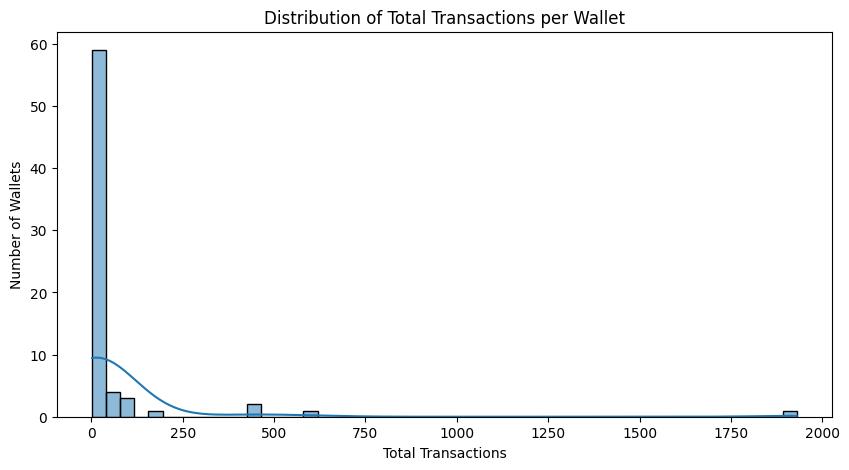

In [115]:
plt.figure(figsize=(10, 5))
sns.histplot(features["total_txns"], bins=50, kde=True)
plt.title("Distribution of Total Transactions per Wallet")
plt.xlabel("Total Transactions")
plt.ylabel("Number of Wallets")
plt.show()
#plt.savefig('Distribution of Total Transactions per Wallet.png')
plt.close()

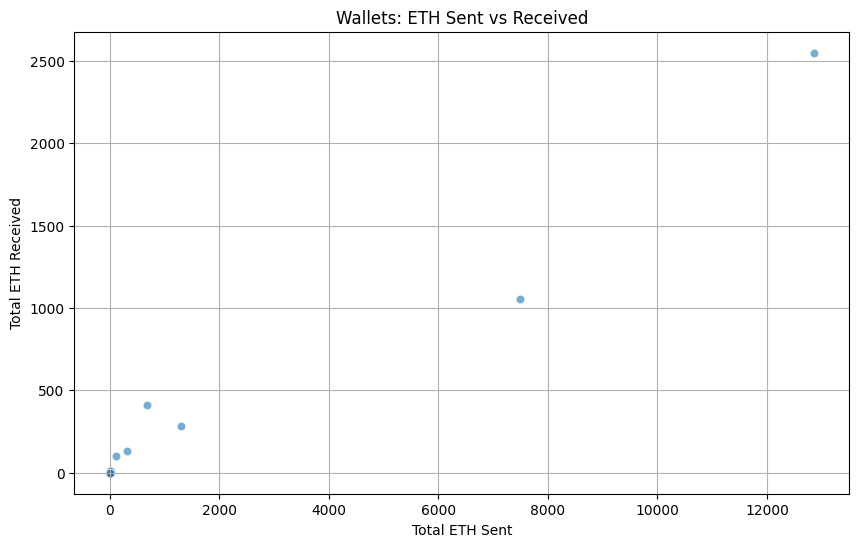

In [116]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="total_sent", y="total_received", data=features, alpha=0.6)
plt.title("Wallets: ETH Sent vs Received")
plt.xlabel("Total ETH Sent")
plt.ylabel("Total ETH Received")
plt.grid(True)
plt.show()
#plt.savefig('Wallets_ETH_Sent_vs_Received.png')
plt.close()



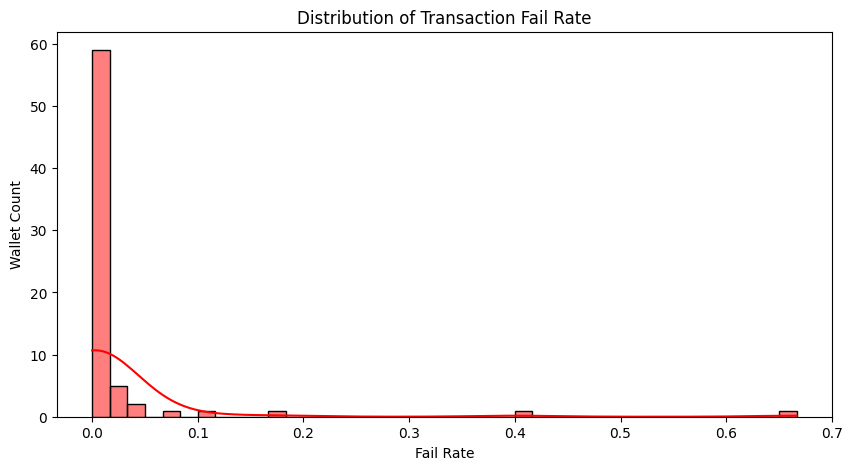

In [117]:
# Distribution of Transaction Fail Rate
plt.figure(figsize=(10, 5))
sns.histplot(features["fail_rate"], bins=40, kde=True, color='red')
plt.title("Distribution of Transaction Fail Rate")
plt.xlabel("Fail Rate")
plt.ylabel("Wallet Count")
plt.show()
#plt.savefig('Distribution_of_Transaction_Fail_Rate.png')
plt.close()


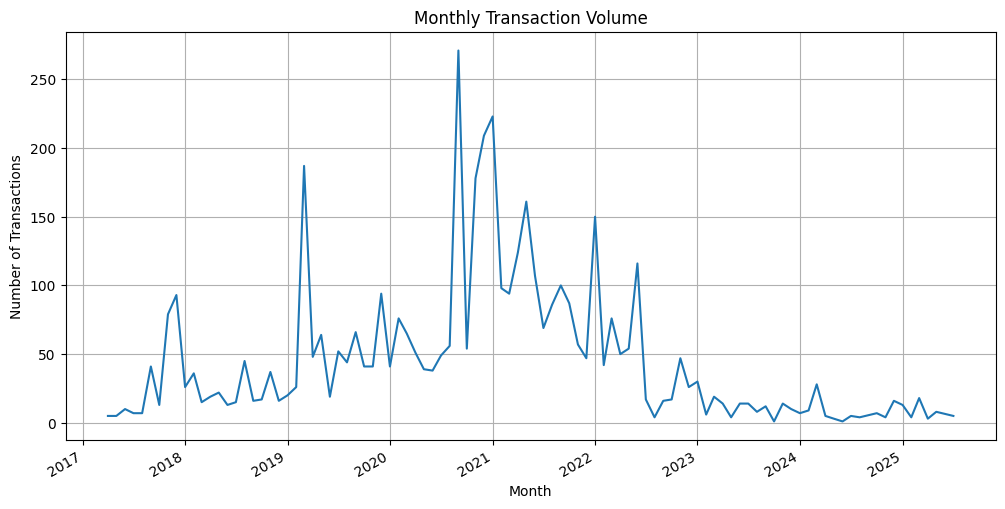

In [118]:
tx_time_series = df_filtered.groupby(df_filtered["timeStamp"].dt.to_period("M")).size()
tx_time_series.index = tx_time_series.index.to_timestamp()

plt.figure(figsize=(12, 6))
tx_time_series.plot()
plt.title("Monthly Transaction Volume")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.grid(True)
plt.show()
#plt.savefig('Monthly_Transaction_Volume.png')
plt.close()


In [119]:

fig = px.scatter(
    features,
    x="txn_per_day",
    y="fail_rate",
    size="total_txns",
    color="net_received",
    hover_name=features.index,
    title="Wallet Risk Patterns (Interactive)",
    labels={
        "txn_per_day": "Transactions Per Day",
        "fail_rate": "Fail Rate",
        "total_txns": "Total Transactions",
        "net_received": "Net ETH Received"
    },
    color_continuous_scale=px.colors.sequential.Viridis # Or any other colormap
)
fig.show()


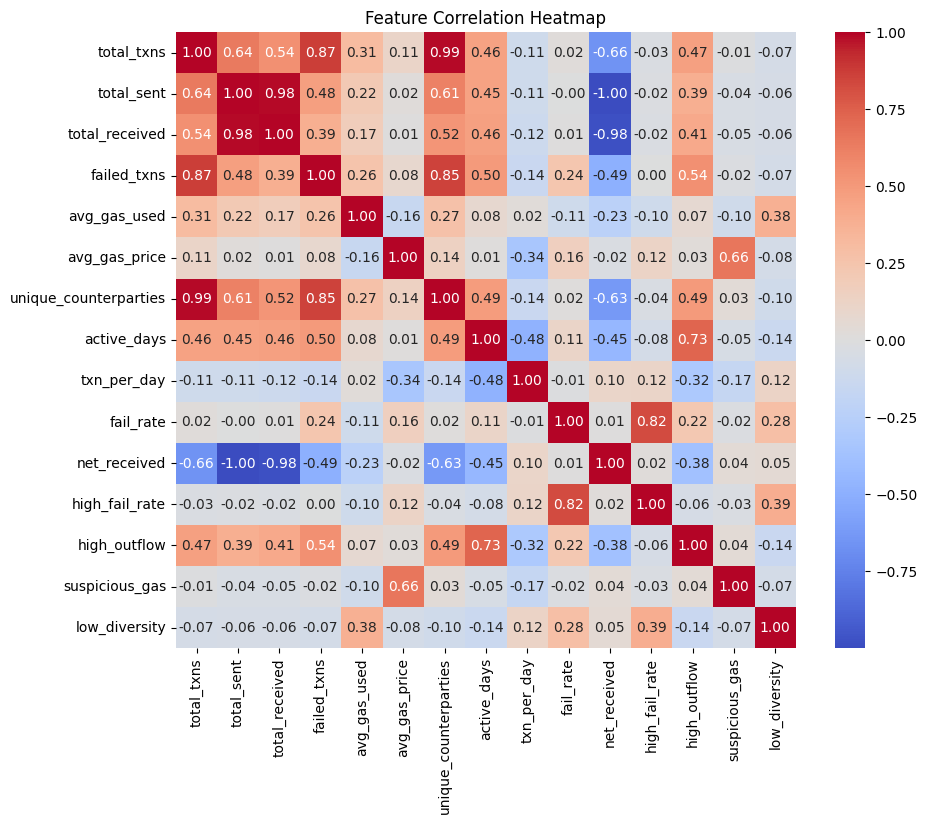

In [120]:
# Feature Correlation Heatmap
plt.figure(figsize=(10, 8))
numeric_features_for_corr = features.select_dtypes(include=np.number).columns
corr = features[numeric_features_for_corr].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()
#plt.savefig('Feature_Correlation_Heatmap.png')
plt.close()


In [121]:
from sklearn.preprocessing import MinMaxScaler

In [122]:
selected_features_for_custom_score = features[[
    "total_txns", "fail_rate", "net_received", "txn_per_day",
    "unique_counterparties", "avg_gas_price"
]].copy()
selected_features_for_custom_score = selected_features_for_custom_score.replace([np.inf, -np.inf], np.nan).fillna(0)

scaler = MinMaxScaler()
normalized_features = pd.DataFrame(
    scaler.fit_transform(selected_features_for_custom_score),
    columns=selected_features_for_custom_score.columns,
    index=selected_features_for_custom_score.index
)

normalized_features["inv_fail_rate"] = 1 - normalized_features["fail_rate"]

normalized_features["good_txn_per_day"] = normalized_features["txn_per_day"]
normalized_features["inv_avg_gas_price"] = 1 - normalized_features["avg_gas_price"]


weights = {
    "inv_fail_rate": 0.25,
    "good_txn_per_day": 0.15,
    "net_received": 0.20,
    "unique_counterparties": 0.15,
    "total_txns": 0.10,
    "inv_avg_gas_price": 0.15
}

score = (
    weights["inv_fail_rate"] * normalized_features["inv_fail_rate"] +
    weights["good_txn_per_day"] * normalized_features["good_txn_per_day"] +
    weights["net_received"] * normalized_features["net_received"] +
    weights["unique_counterparties"] * normalized_features["unique_counterparties"] +
    weights["total_txns"] * normalized_features["total_txns"] +
    weights["inv_avg_gas_price"] * normalized_features["inv_avg_gas_price"]
)


features["risk_score"] = (score * 1000).round().astype(int)


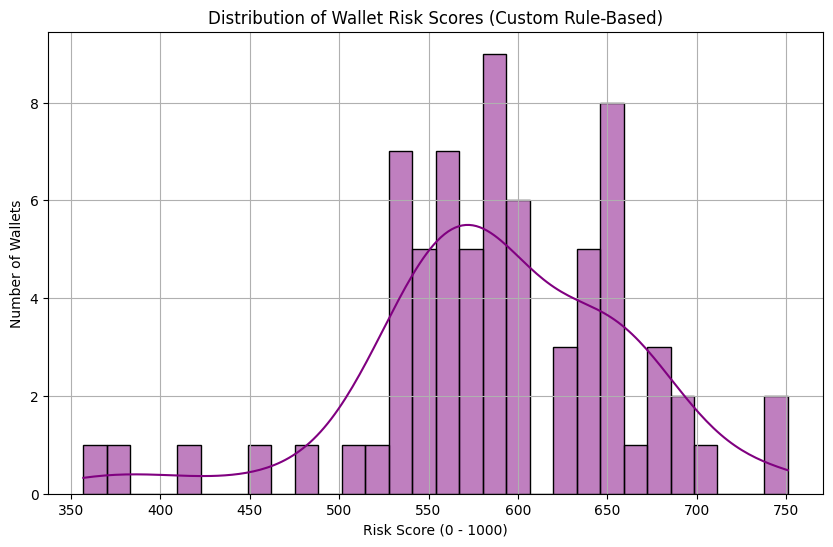

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
# Distribution of Wallet Risk Scores (Custom Rule-Based)
plt.figure(figsize=(10, 6))
sns.histplot(features["risk_score"], bins=30, kde=True, color='purple')
plt.title("Distribution of Wallet Risk Scores (Custom Rule-Based)")
plt.xlabel("Risk Score (0 - 1000)")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()
#plt.savefig('Distribution_of_Wallet_Risk_Scores_Custom.png')
plt.close()

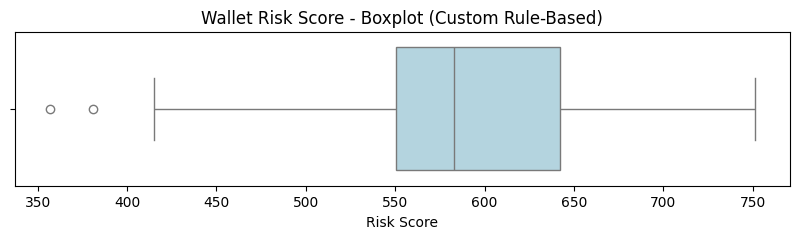

In [124]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=features, x="risk_score", color='lightblue')
plt.title("Wallet Risk Score - Boxplot (Custom Rule-Based)")
plt.xlabel("Risk Score")
plt.show()
#plt.savefig('Wallet_Risk_Score_Boxplot_Custom.png')
plt.close()

In [125]:
def risk_label(score):
    if score >= 750:
        return "Low Risk"
    elif score >= 500:
        return "Medium Risk"
    else:
        return "High Risk"

features["risk_category"] = features["risk_score"].apply(risk_label)

/tmp/ipython-input-126-1834664738.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




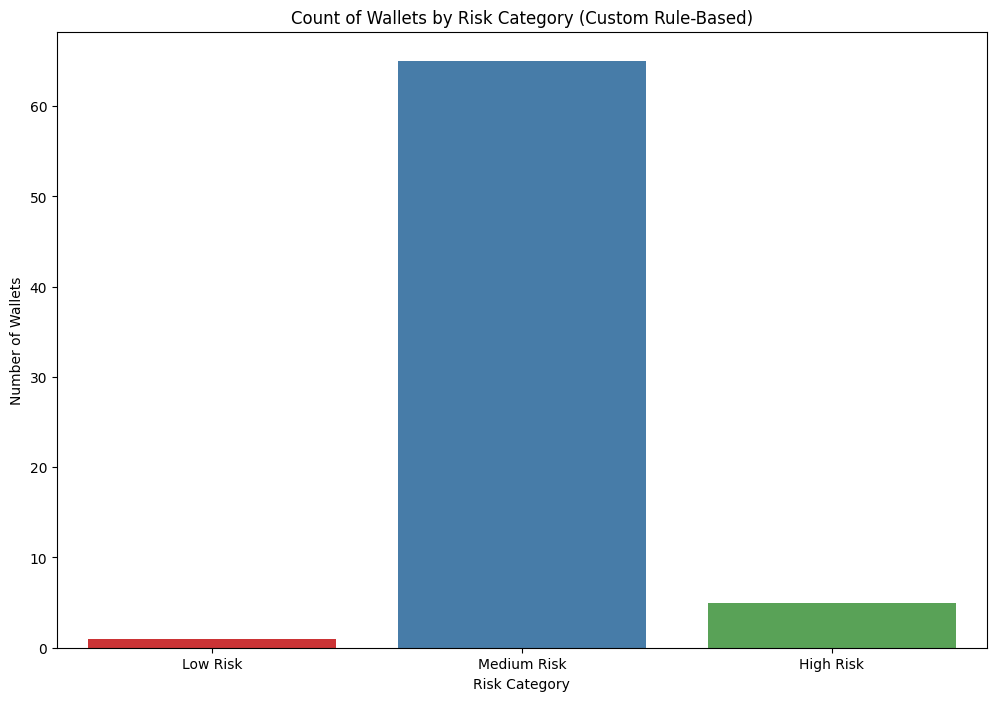

In [126]:
plt.figure(figsize=(12, 8))
sns.countplot(data=features, x="risk_category", palette="Set1", order=["Low Risk", "Medium Risk", "High Risk"])
plt.title("Count of Wallets by Risk Category (Custom Rule-Based)")
plt.xlabel("Risk Category")
plt.ylabel("Number of Wallets")
plt.show()
#plt.savefig('Count_of_Wallets_by_Risk_Category_Custom.png')
plt.close()

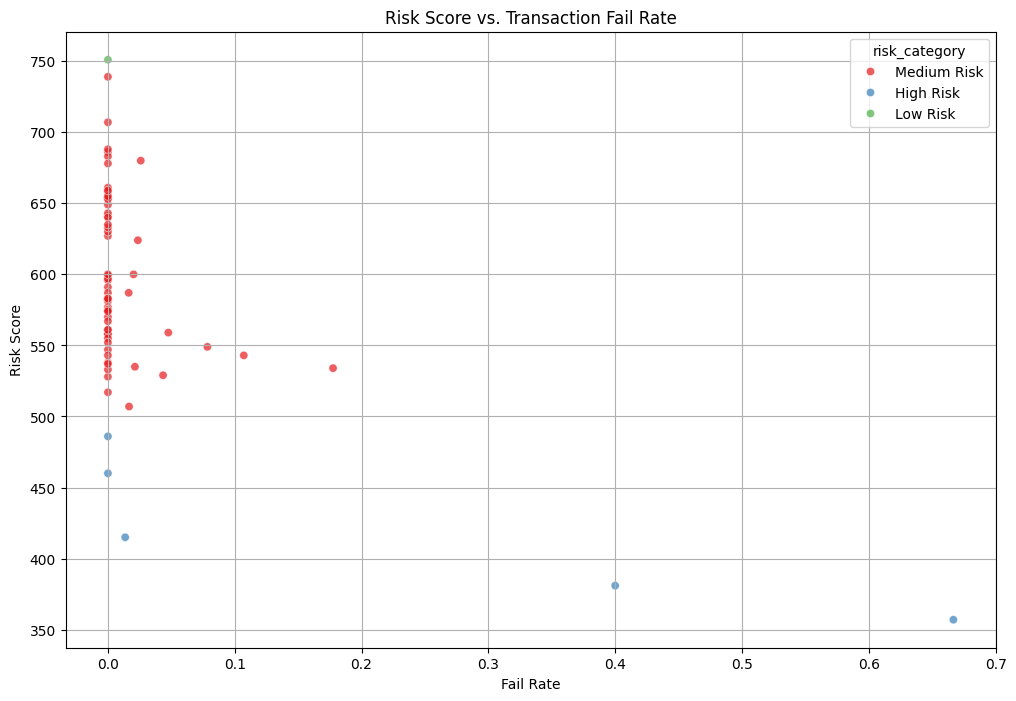

In [127]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=features, x="fail_rate", y="risk_score", hue="risk_category", palette="Set1", alpha=0.7)
plt.title("Risk Score vs. Transaction Fail Rate")
plt.xlabel("Fail Rate")
plt.ylabel("Risk Score")
plt.grid(True)
plt.show()
#plt.savefig('Risk_Score_Custom_vs_Fail_Rate.png')
plt.close()


In [128]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

X = features[[
    "total_txns", "fail_rate", "net_received", "txn_per_day",
    "unique_counterparties", "avg_gas_price"
]].copy()

y = features["risk_score"]


X = X.replace([np.inf, -np.inf], np.nan).fillna(X.mean())
y = y.replace([np.inf, -np.inf], np.nan).fillna(y.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [129]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "MLP": MLPRegressor(max_iter=1000, random_state=42)
}

results = []
best_r2 = -float('inf')
best_model_name = ""
best_model_instance = None

for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results.append({
            "Model": name,
            "MAE": round(mae, 2),
            "RMSE": round(rmse, 2),
            "R²": round(r2, 4)
        })

        if r2 > best_r2:
            best_r2 = r2
            best_model_name = name
            best_model_instance = model
    except Exception as e:
        results.append({
            "Model": name,
            "MAE": "N/A",
            "RMSE": "N/A",
            "R²": "N/A"
        })


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



In [131]:
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
print(results_df)

if best_model_instance:
    print(f"\nBest performing model based on R²: {best_model_name}")
    features["ml_risk_score"] = best_model_instance.predict(X)
else:
    print("\nNo best model found.")

    lin_reg_model = LinearRegression()
    lin_reg_model.fit(X_train, y_train)
    features["ml_risk_score"] = lin_reg_model.predict(X)

               Model     MAE    RMSE       R²
0  Linear Regression    0.28    0.32   1.0000
2              Lasso    4.33    6.05   0.9887
1              Ridge   11.45   17.07   0.9102
7                KNN   44.53   56.78   0.0062
6                SVR   42.57   58.50  -0.0547
5  Gradient Boosting   32.80   60.23  -0.1181
4      Random Forest   36.04   63.29  -0.2347
3      Decision Tree   41.20   77.19  -0.8362
8                MLP  286.80  385.61 -44.8280

Best performing model based on R²: Linear Regression


In [132]:
features["ml_risk_score"] = features["ml_risk_score"].clip(0, 1000).round().astype(int)

features = features.reset_index()

output = features[["wallet", "ml_risk_score"]].copy()
output.columns = ["wallet_id", "score"]
output.to_csv("wallet_risk_scores.csv", index=False)
